In [23]:
import cv2,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from poe.bulk.predictions import *
from itertools import groupby
from pathlib import Path 
from poe.bulk.image_cutter import *
import hashlib
from collections import defaultdict
import easyocr
from Levenshtein.StringMatcher import StringMatcher
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
plt.style.use('dark_background')
%matplotlib inline

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [24]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ €ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [25]:
def parse_numbers(img):
    assert img.shape[0]*img.shape[1]>0
    cols_of_interest=[1,6,8,11,13,14,19,21,24,26]

    try:
        frags=cut_image_to_frags(img)
    except Exception as e: 
        print(f'{path,img_hash} could not be processed:{e}')
        plt.figure(figsize=(20,20))
        plt.imshow(img)
    results=defaultdict(dict)
    for col in cols_of_interest:
        for row,frag in enumerate(frags[col]):
            _frag=normalize_frag(frag,target=(32,80))
            result = predict_wrapper(_frag)
            results[col][row]=result
    return results
def parse_text(img,reader):
    assert img.shape[0]*img.shape[1]>0
    cols_of_interest=[4,17]
    try:
        frags=cut_image_to_frags(img)
    except Exception as e: 
        print(f'{path,img_hash} could not be processed:{e}')
        plt.figure(figsize=(20,20))
        plt.imshow(img)
    results=defaultdict(dict)
    for col in cols_of_interest:
        
        for row,frag in enumerate(frags[col]):
            result=reader.readtext(frag)
            
            if result:
                results[col][row]=result[0][1]
    return results

In [26]:
path='poe/bulk/data/tabs/unknown (25).png'


0


/Users/swozny/work/poe/venv/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


,1,6,8,11,13,14,19,21,24,26
0,11,25,23.25,255.75,1.59,7,32,29.76,200.32,1.29
1,23,8.94,8.31,191.13,1.19,11,17,15.81,177.91,1.08
2,13,10.73,9.98,129.74,0.8,8,15,13.95,111.6,0.69
3,28,3.92,3.65,102.2,0.63,15,7,6.51,97.65,0.61
4,4,24,22.32,88.28,0.55,2,36,33.48,66.96,0.42


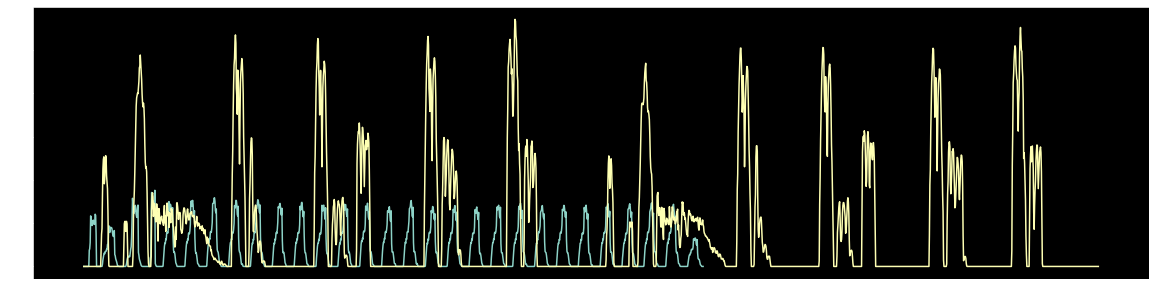

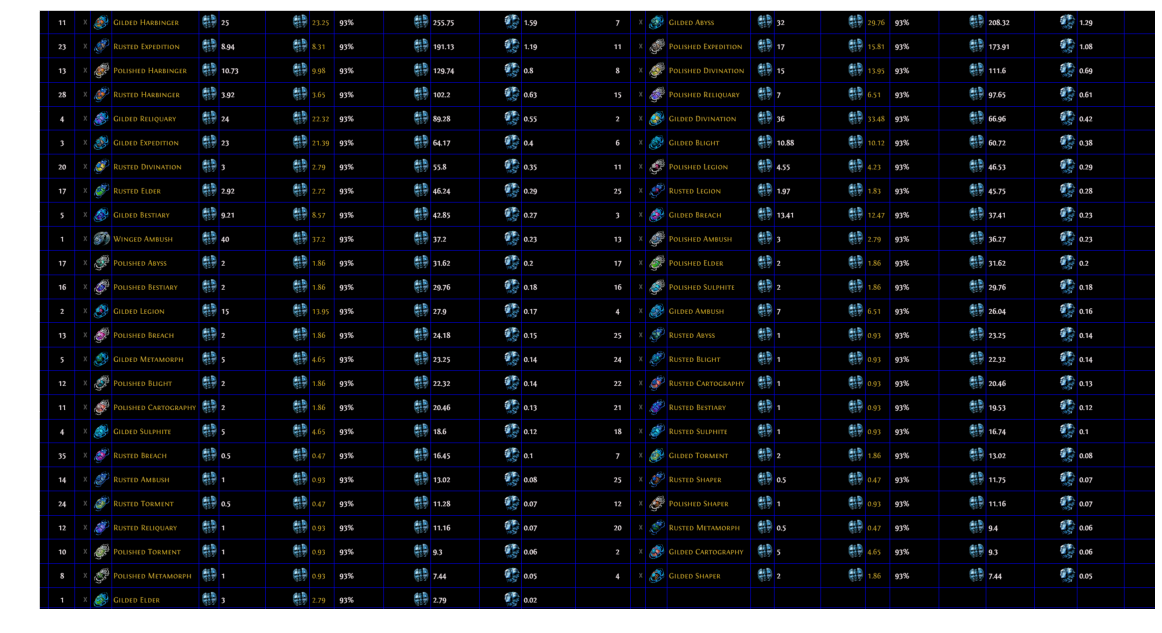

In [27]:
img=cv2.imread(path)
results=parse_numbers(img)
numbers=pd.DataFrame(results)
numbers.head()

0


,4,17
0,Gilded Harbinger,Gilded Abvss
1,Rusted Expedition,Polished Expedition
2,PoLsHed Harbinger,Polished Divination
3,Rusted Harbinger,Polished Rellquarv
4,Gilded Reliquary,Gilded Dvination


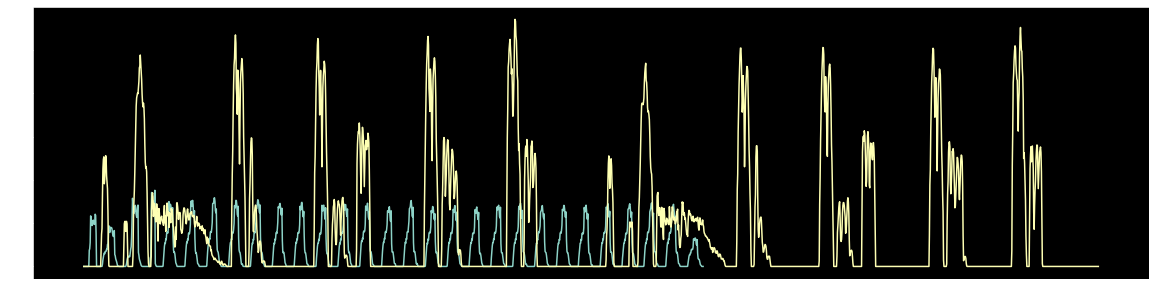

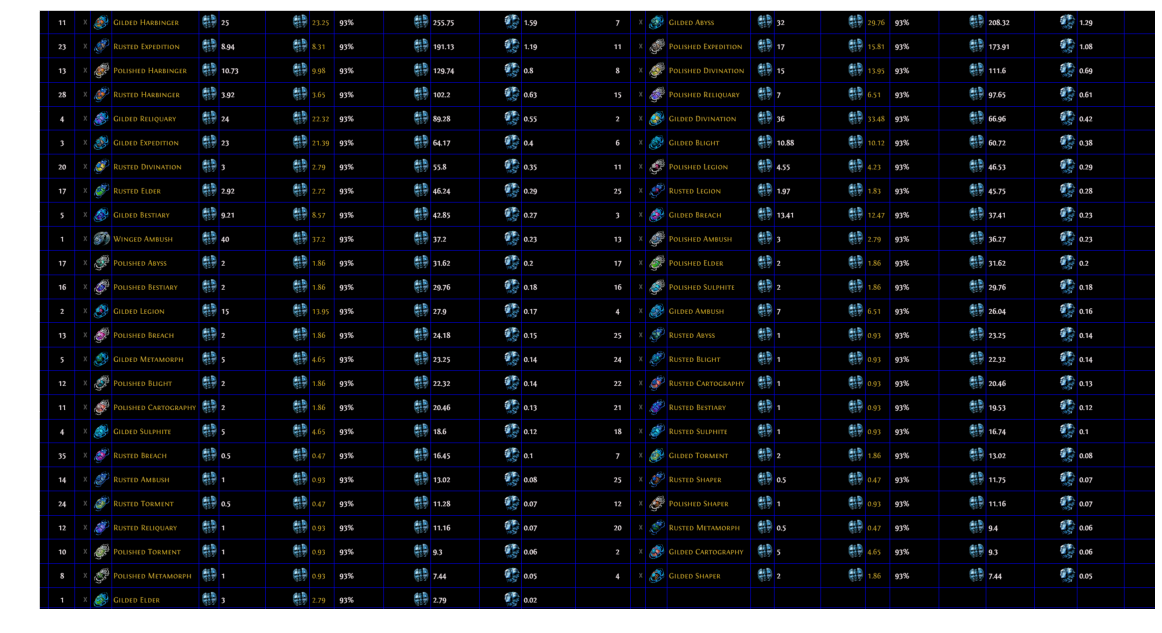

In [28]:
img=cv2.imread(path)
strings=pd.DataFrame(parse_text(img, reader))
strings.head()

In [29]:
from poe.scarabs.main import scarab_orb_of_horizon
df=scarab_orb_of_horizon().sort_values('profit')
df=df.reset_index()
df['name']=(df.tier+' '+df.kind).str.lower()
strings_processed=strings.applymap(lambda x: max([(StringMatcher(seq1=str(x).lower(),seq2=str(y).lower()).ratio(),y,x) for y in df['name']])[1])
scarab_values=df
scarab_values['valuation']=scarab_values[['price','value']].max(axis=1)
scarab_values.head()

https://poe.ninja/api/data/itemoverview Scarab 200


,tier,kind,profitability,profit,price,value,name,valuation
0,Winged,Breach,-0.796883,-78.094570,98.00,19.905430,winged breach,98.00
1,Winged,Abyss,-0.796260,-77.826445,97.74,19.913555,winged abyss,97.74
2,Winged,Reliquary,-0.761039,-64.688320,85.00,20.311680,winged reliquary,85.00
3,Winged,Divination,-0.744151,-59.532070,80.00,20.467930,winged divination,80.00
4,Winged,Harbinger,-0.725011,-54.375820,75.00,20.624180,winged harbinger,75.00


In [96]:
df=numbers.join(strings_processed)
df=df[sorted(df.columns)].rename({1:'quantity',4:'name',6:'price',8:'asking_price',11:'total_chaos',13:'total_exalt',14:'quantity',17:'name',19:'price',21:'asking_price',24:'total_chaos',26:'total_exalt'},axis=1)
left=df.iloc[:,int(len(df.columns)/2):]
right=df.iloc[:,:int(len(df.columns)/2)]
df=pd.concat([left,right],ignore_index=True,axis=0)
df=df[df.price!='']
df


,quantity,name,price,asking_price,total_chaos,total_exalt
0,7,gilded abyss,32,29.76,200.32,1.29
1,11,polished expedition,17,15.81,177.91,1.08
2,8,polished divination,15,13.95,111.6,0.69
3,15,polished reliquary,7,6.51,97.65,0.61
4,2,gilded divination,36,33.48,66.96,0.42
5,6,gilded blight,10.88,10.12,60.72,0.38
6,11,polished legion,4.55,4.23,46.53,0.29
7,25,rusted legion,1.97,1.83,45.75,0.28
8,3,gilded breach,13.41,12.47,37.41,0.23
9,13,polished ambush,3,2.79,36.27,0.23


In [100]:
df=df.set_index('name').join(scarab_values.set_index('name'),rsuffix='own')

In [101]:
df.head()

,quantity,price,asking_price,total_chaos,total_exalt,tier,kind,profitability,profit,priceown,value,valuation
name,,,,,,,,,,,,
gilded abyss,7,32,29.76,200.32,1.29,Gilded,Abyss,-0.804659,-25.749102,32.00,6.250898,32.00
polished expedition,11,17,15.81,177.91,1.08,Polished,Expedition,-0.885605,-15.055293,17.00,1.944707,17.00
polished divination,8,15,13.95,111.6,0.69,Polished,Divination,-0.866186,-12.992793,15.00,2.007207,15.00
polished reliquary,15,7,6.51,97.65,0.61,Polished,Reliquary,-0.663897,-4.474668,6.74,2.265332,6.74
gilded divination,2,36,33.48,66.96,0.42,Gilded,Divination,-0.829836,-29.874102,36.00,6.125898,36.00


In [103]:
(df.quantity.astype('float')*df.valuation.astype('float')).sum()

2826.1141796875

In [33]:
scarab_values.head()

,tier,kind,profitability,profit,price,value,name,valuation
0,Winged,Breach,-0.796883,-78.094570,98.00,19.905430,winged breach,98.00
1,Winged,Abyss,-0.796260,-77.826445,97.74,19.913555,winged abyss,97.74
2,Winged,Reliquary,-0.761039,-64.688320,85.00,20.311680,winged reliquary,85.00
3,Winged,Divination,-0.744151,-59.532070,80.00,20.467930,winged divination,80.00
4,Winged,Harbinger,-0.725011,-54.375820,75.00,20.624180,winged harbinger,75.00
